In [1]:
import os
os.chdir("/home/studio-lab-user/sagemaker-studiolab-notebooks/AI-OT-24/Reinforcement-Learning-Stock-Porfolio-Managment")
!pip install -q -r requirements.txt
import sys
sys.path.append('./utils')
from trading_functions import *
# Core Libraries
import os
import sys
import time
import datetime
import warnings
import itertools
#warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = info, 2 = warnings, 3 = errors

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

# Financial Data
import yfinance as yf
import quantstats as qs
import ta

# Machine Learning - Supervised Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Machine Learning - Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy

# Reinforcement Learning and Environments
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import A2C, DDPG, DQN, HER, PPO, SAC, TD3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import (
    EvalCallback, StopTrainingOnRewardThreshold, StopTrainingOnNoModelImprovement
)
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecCheckNan, VecNormalize
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from sb3_contrib import ARS, MaskablePPO, RecurrentPPO, QRDQN, TRPO

# Imitation Learning
from imitation.algorithms import bc
from imitation.testing.reward_improvement import is_significant_reward_improvement
from imitation.data.types import Transitions

# Interactive Brokers API
from ib_insync import *

from typing import Callable

from collections import Counter

clear_output()


In [2]:
# Define constants
SEED = 1
history_length = [1, 2, 4, 5, 6, 8, 10, 16, 20]
history_length.reverse()
reward_type = 'LNR'
stocks = ['TGT', 'MARA', 'GOOGL', 'WMT', 'V', 'PG'] #['AAPL', 'AMZN', 'META', 'MSFT', 'NVDA', 'TSLA']
start_date = '2024-01-01'
end_date = '2024-12-01'
n_envs = 8
n_steps = 16
total_timesteps = 10_000
batch_size = 32
learning_rate = 0.0001
ent_coef = 0.05
log_interval = 1_000
eval_freq = 1_000
model_name= 'A2C'

Stage 1: Set time intervals

In [3]:
# Training environment
env = create_training_env(history_length[0], reward_type, start_date, end_date, stocks, 1)[0]

Stage 1: Multiple stock learning

In [4]:
envs=[]
models = []
for h in range(9):
    envs.append(create_training_env(history_length[h], reward_type, start_date, end_date, stocks, 1)[0])
    for i in range(6):
        model_save_dir = f'./models/history_length/{history_length[h]}/{i}'
        models.append(A2C.load(model_save_dir,envs[h]))
    model_save_dir = f'./models/history_length/{history_length[h]}/best_model'
    models.append(A2C.load(model_save_dir,envs[h]))
from collections import Counter

In [5]:
env = envs[0]

Total return of portfolio: -93.36%
Total reward: -3.1025859896353105


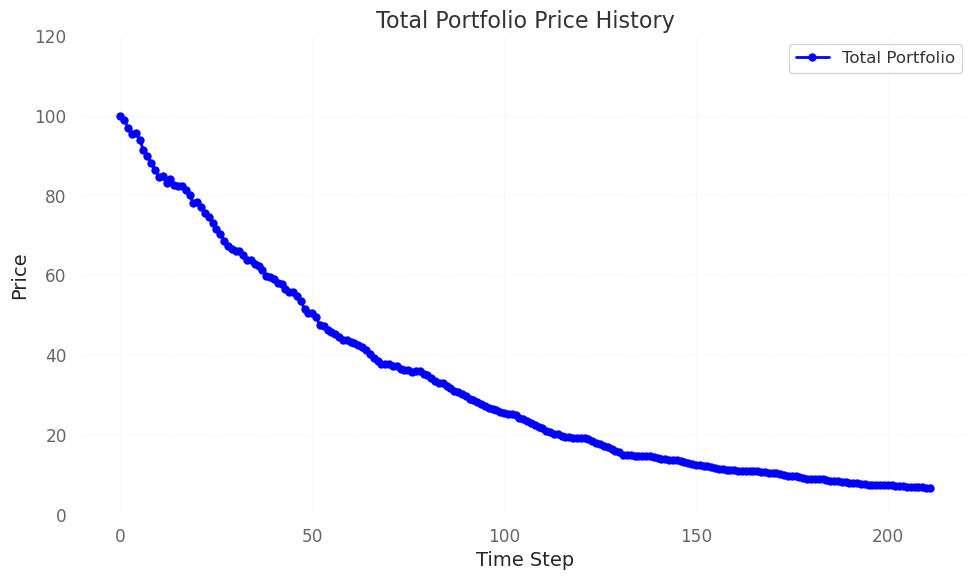

In [6]:
observation, info = env.reset(seed=SEED)
total_reward = 0
has_policy = False
while True:
    actions = []
    # Get actions from models
    action = env.action_space.sample()
    # Step in the environment
    observation, reward, done, _, _ = env.step(action)

    # Accumulate total reward
    total_reward += reward

    if done:
        break
_ = env.returns()
print(f"Total reward: {total_reward}")
env.render('total')

[3, 3, 3, 3, 6, 6, 3, 5, 4, 5, 0, 0, 2, 0, 2, 0, 0, 2, 5, 5, 0, 5, 0, 0, 0, 0, 2, 0, 5, 0, 5, 5, 0, 5, 0, 2, 0, 3, 5, 5, 5, 5, 1, 2, 2, 0, 5, 5, 0, 5, 4, 5, 5, 5, 2, 4, 2, 2, 5, 5, 5, 5, 5] 5
[2, 3, 3, 3, 3, 1, 3, 5, 4, 5, 0, 0, 2, 0, 2, 4, 0, 2, 5, 5, 0, 5, 4, 0, 0, 5, 5, 4, 5, 0, 5, 5, 0, 5, 0, 2, 2, 3, 5, 5, 5, 5, 1, 2, 2, 0, 5, 5, 2, 5, 4, 5, 5, 5, 5, 4, 2, 2, 5, 2, 5, 5, 2] 5
[2, 3, 3, 3, 6, 6, 3, 5, 3, 5, 5, 5, 2, 0, 2, 0, 0, 2, 5, 5, 0, 5, 4, 0, 0, 5, 5, 0, 5, 0, 5, 5, 0, 5, 0, 2, 0, 3, 5, 5, 5, 5, 1, 0, 2, 0, 5, 5, 2, 5, 4, 5, 5, 5, 2, 4, 2, 2, 5, 5, 5, 5, 5] 5
[2, 3, 3, 3, 6, 6, 3, 5, 3, 5, 0, 5, 2, 0, 2, 6, 3, 3, 6, 3, 0, 1, 0, 0, 0, 0, 5, 0, 5, 0, 5, 5, 0, 5, 0, 2, 0, 3, 5, 5, 5, 5, 1, 2, 2, 0, 5, 5, 0, 5, 4, 5, 5, 5, 2, 4, 2, 2, 5, 5, 5, 5, 5] 5
[2, 3, 3, 1, 0, 1, 1, 5, 3, 5, 5, 5, 5, 5, 2, 0, 0, 2, 5, 2, 0, 1, 0, 5, 6, 6, 5, 0, 5, 0, 5, 5, 0, 5, 0, 2, 0, 3, 5, 5, 5, 5, 1, 2, 2, 0, 5, 5, 0, 5, 4, 5, 5, 5, 2, 4, 2, 2, 5, 5, 5, 5, 5] 5
[2, 3, 3, 0, 5, 0, 3, 5, 3, 5, 5, 5, 5, 

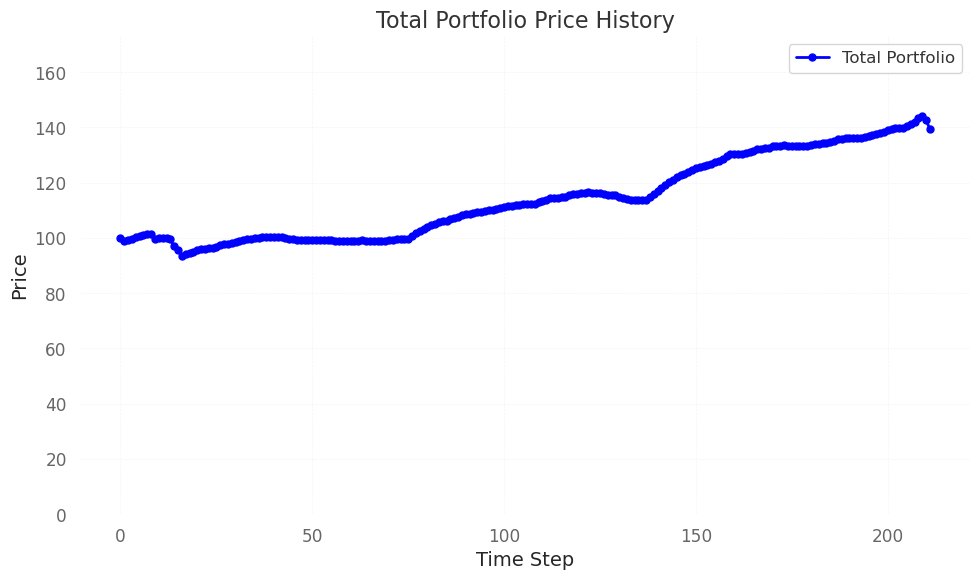

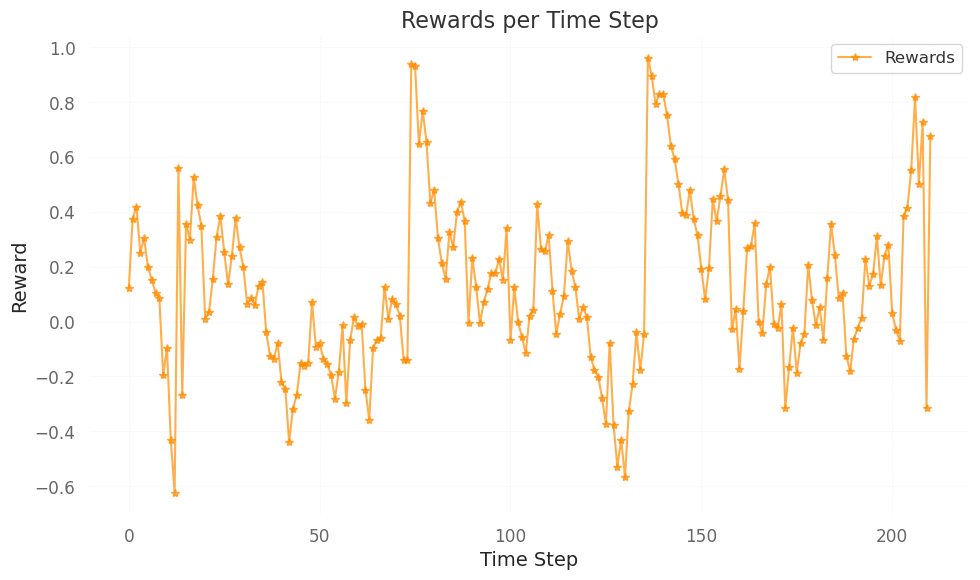

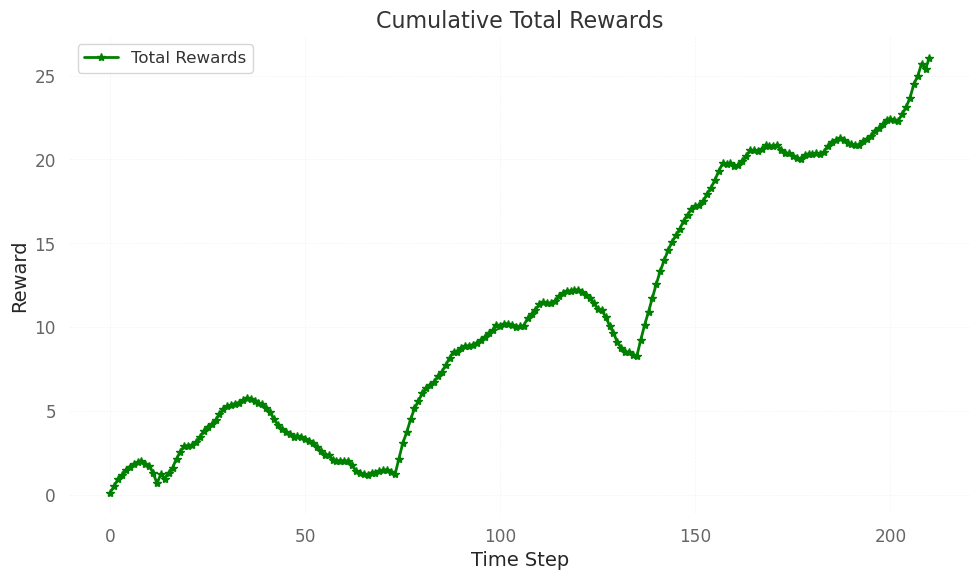

Total rewards: 26.077963751519537


In [7]:
# Initialize the environment and variables

observation, info = env.reset(seed=SEED)
total_reward = 0
has_policy = False
while True:
    actions = []
    for h in range(9):
        # Get actions from models
        if has_policy:
            for i in range(7):
                actions.append(int(models[7*h+i].policy.predict(observation[-(envs[h].ColSize*envs[h].num_stocks*envs[h].history_length):], deterministic=True)[0]))
        else:
            for i in range(7):
                actions.append(int(models[7*h+i].predict(observation[-(envs[h].ColSize*envs[h].num_stocks*envs[h].history_length):], deterministic=True)[0]))

    # Convert actions to hashable types (e.g., integers or tuples)
    action = Counter(actions).most_common(1)[0][0]
    print(actions,action)

    # Step in the environment
    observation, reward, done, _, _ = env.step(action)

    # Accumulate total reward
    total_reward += reward

    if done:
        break
_ = env.returns()
print(f"Total reward: {total_reward}")
env.render('total')
env.render('rewards')
     
#env.close()
#del env 

Total return of portfolio: 6.67%
Total reward: -5.8510197148649095


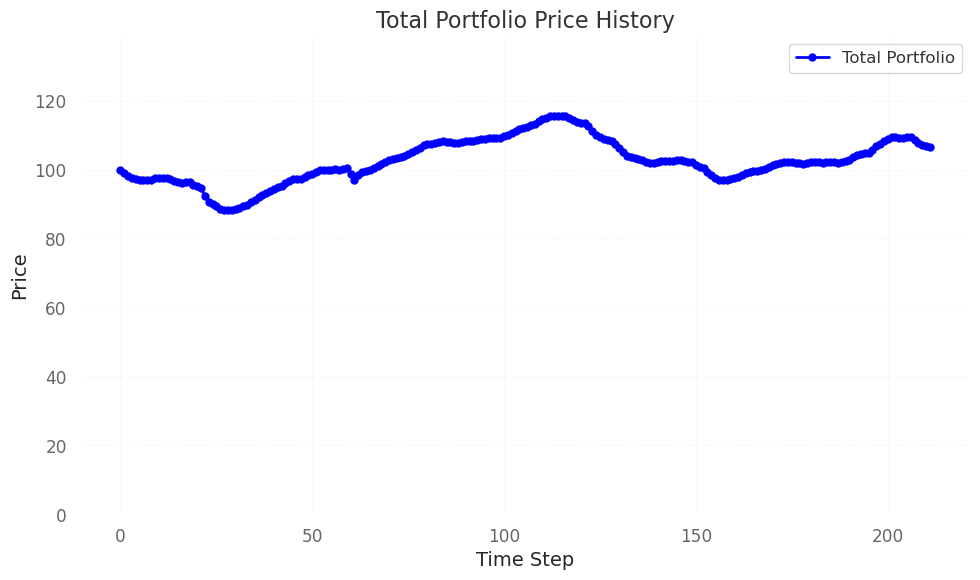

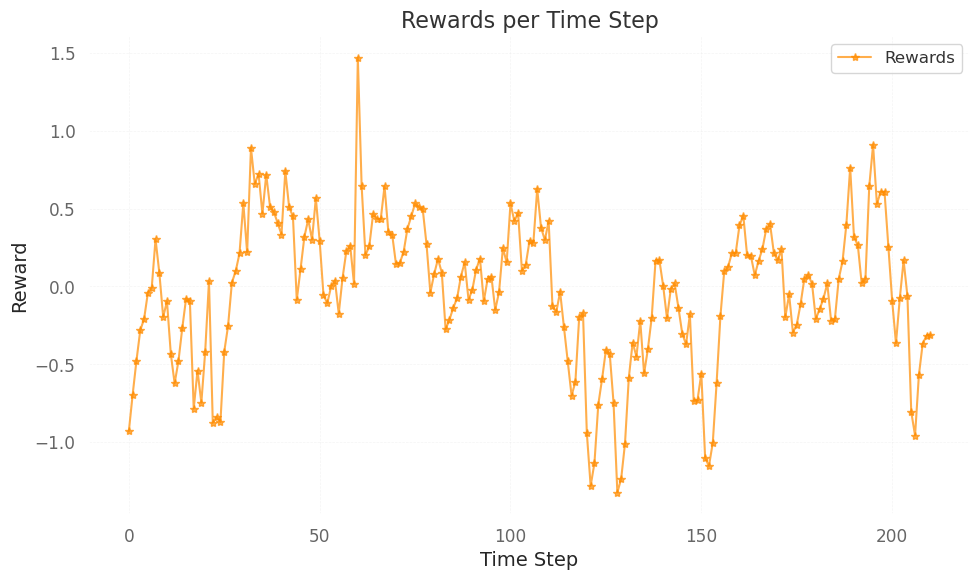

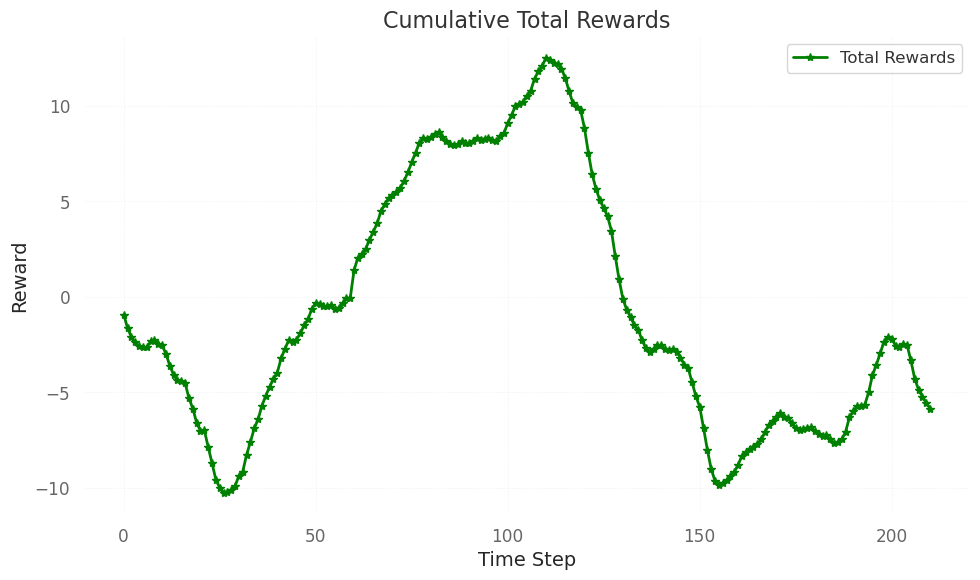

Total rewards: -5.8510197148649095


In [8]:
# Initialize the environment and variables
#for i in range(7):

observation, info = env.reset(seed=SEED)
total_reward = 0
has_policy = False
while True:
    actions = []
    # Get actions from models
    if has_policy:
        for i in range(9):
            actions.append(int(models[6+7*i].policy.predict(observation[-(envs[i].ColSize*envs[i].num_stocks*envs[i].history_length):], deterministic=True)[0]))
    else:
        for i in range(9):
            actions.append(int(models[6+7*i].predict(observation[-(envs[i].ColSize*envs[i].num_stocks*envs[i].history_length):], deterministic=True)[0]))

    # Convert actions to hashable types (e.g., integers or tuples)
    action = Counter(actions).most_common(1)[0][0]
    #print(actions,action)

    # Step in the environment
    observation, reward, done, _, _ = env.step(action)

    # Accumulate total reward
    total_reward += reward

    if done:
        break
_ = env.returns()
print(f"Total reward: {total_reward}")
env.render('total')
env.render('rewards')
     
env.close()
del env 